데이터 전처리

STF 데이터

In [1]:
import json

with open('kochatgpt_1_SFT.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_api_result_jsonl_load = json.load(json_file)

In [2]:
import pandas as pd

df = pd.DataFrame(list_api_result_jsonl_load)
df.head()

,prompt,completion,tokens
0,불고기용 고기 한우에요?,"'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하...",193
1,쓰던 앱이 유료로 전환됐어,"'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 ...",288
2,여친이랑 다툼,'저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하...,153
3,술 먹고 싶어,"'술은 알코올이 함유된 음료수이며, 건강에 나쁜 영향을 미칠 수 있습니다. 따라서 ...",189
4,잊고싶다.,'저도 인공지능 엔진으로써 사용자의 개인정보나 감정을 침해할 수 없습니다. 그렇기 ...,147


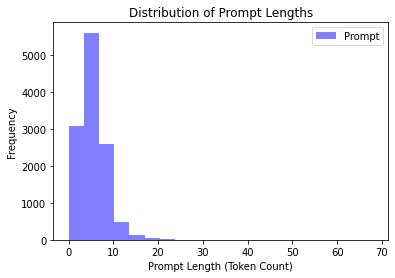

In [3]:
import matplotlib.pyplot as plt


# prompt와 completion의 길이(토큰 수) 계산 및 데이터프레임에 추가
df['prompt_length'] = df['prompt'].apply(lambda x: len(x.split()))

# Create a histogram for 'Prompt' lengths
plt.hist(df['prompt_length'], bins=20, color='blue', alpha=0.5, label='Prompt')
plt.xlabel('Prompt Length (Token Count)')
plt.ylabel('Frequency')
plt.title('Distribution of Prompt Lengths')
plt.legend()
plt.show()


In [4]:
# 토큰 수가 10보다 큰 'prompt' 데이터 제거
df = df[df['prompt'].apply(lambda x: len(x.split()) <= 10)]


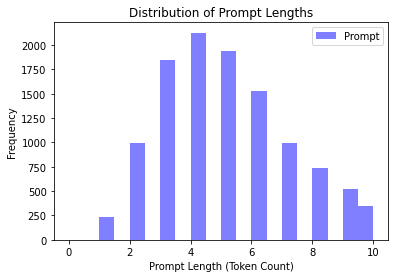

In [5]:
import matplotlib.pyplot as plt


# prompt와 completion의 길이(토큰 수) 계산 및 데이터프레임에 추가
df['prompt_length'] = df['prompt'].apply(lambda x: len(x.split()))

# Create a histogram for 'Prompt' lengths
plt.hist(df['prompt_length'], bins=20, color='blue', alpha=0.5, label='Prompt')
plt.xlabel('Prompt Length (Token Count)')
plt.ylabel('Frequency')
plt.title('Distribution of Prompt Lengths')
plt.legend()
plt.show()

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from konlpy.tag import Okt

# KoNLPy의 Okt 객체 생성
okt = Okt()

# 불용어 리스트 생성 (예시입니다. 실제로는 더 많은 불용어가 필요할 수 있습니다.)
stopwords = ['은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']

# 토큰화 및 불용어 제거 함수 정의
def preprocess(text):
    text = okt.morphs(text, stem=True) # 토큰화
    text = [word for word in text if word not in stopwords] # 불용어 제거
    return text

# Combine 'prompt' and 'completion' into a single text column
df['text'] = df['prompt'] + " " + df['completion']

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=preprocess, token_pattern=None)

# Fit and transform the vectorizer on our corpus
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.cluster import KMeans


# Define the encoding dimension
encoding_dim = 2

# Define the intermediate dimension
intermediate_dim = 128
intermediate_dim2 = 64

# Get the number of features (i.e., the dimension of the input)
input_dim = tfidf_matrix.shape[1]

# Define the encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(intermediate_dim, activation='relu')(input_layer)
encoded = Dense(intermediate_dim2, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# Define the decoder
decoded = Dense(intermediate_dim2, activation='relu')(encoded)
decoded = Dense(intermediate_dim, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Define the autoencoder model
autoencoder = Model(input_layer, decoded)

# Define the encoder model
encoder = Model(input_layer, encoded)

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()




Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25943)]           0         
_________________________________________________________________
dense (Dense)                (None, 128)               3320832   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 25943)             334664

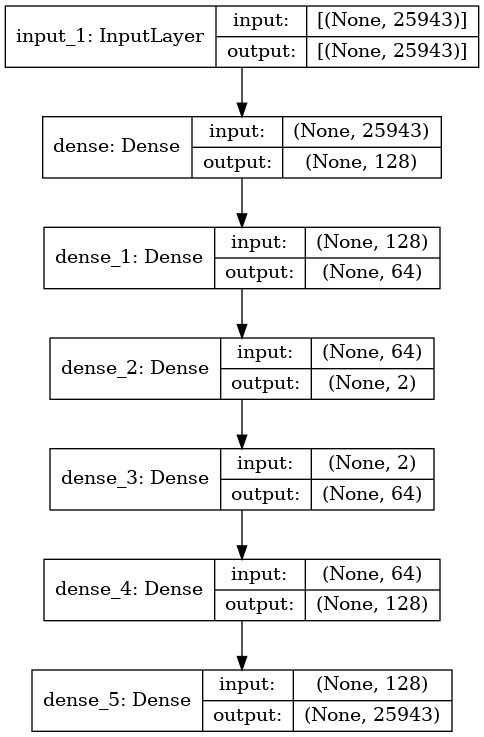

In [8]:
from tensorflow.keras.utils import plot_model

plot_model(
    autoencoder, 'ae_model.png', show_shapes=True
)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='loss', patience=3)

# Train the autoencoder
autoencoder.fit(
    tfidf_matrix.toarray(),
    tfidf_matrix.toarray(),
    epochs=50,
    callbacks=[early_stopping]
)

# Encode the TF-IDF vectors
encoded_features = encoder.predict(tfidf_matrix.toarray())

# Cluster the encoded features
kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(encoded_features)

# Get the cluster labels
df['cluster_label'] = kmeans.labels_

Epoch 1/50
353/353 [==============================] - 3s 6ms/step - loss: 0.0765
Epoch 2/50
353/353 [==============================] - 2s 6ms/step - loss: 0.0015
Epoch 3/50
353/353 [==============================] - 2s 6ms/step - loss: 0.0015
Epoch 4/50
353/353 [==============================] - 2s 6ms/step - loss: 0.0015
Epoch 5/50
353/353 [==============================] - 2s 6ms/step - loss: 0.0015
Epoch 6/50
353/353 [==============================] - 2s 6ms/step - loss: 0.0014
Epoch 7/50
353/353 [==============================] - 2s 6ms/step - loss: 0.0014
Epoch 8/50
353/353 [==============================] - 2s 6ms/step - loss: 0.0014
Epoch 9/50
353/353 [==============================] - 2s 6ms/step - loss: 0.0014
Epoch 10/50
353/353 [==============================] - 2s 6ms/step - loss: 0.0014
Epoch 11/50
353/353 [==============================] - 2s 6ms/step - loss: 0.0014
Epoch 12/50
353/353 [==============================] - 2s 6ms/step - loss: 0.0014
Epoch 13/50
353/353 [====

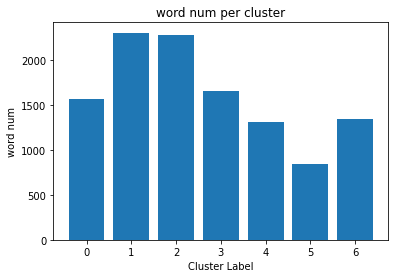

In [10]:
import matplotlib.pyplot as plt

# 군집별 문장 개수 계산
cluster_counts = df['cluster_label'].value_counts()

# 바 그래프 그리기
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster Label')
plt.ylabel('word num')
plt.title('word num per cluster')
plt.show()

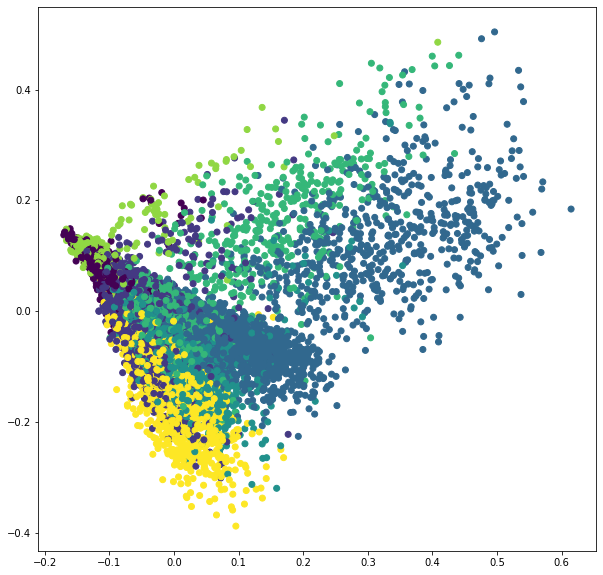

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to the tfidf_matrix
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

# scatter plot
plt.figure(figsize=(10,10))
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=df['cluster_label'])
plt.show()


In [12]:
!pip install koeda

In [13]:
from koeda import EDA
import numpy as np

def run_eda(text):
    return eda(text, p=(0.9, 0.9, 0.9, 0.9), repetition=1)

eda = EDA(
    morpheme_analyzer="Okt", alpha_sr=0.3, alpha_ri=0.0, alpha_rs=0.0, prob_rd=0.3
)

for i in [4, 5, 6]:
    df_cluster3 = df[df['cluster_label'] == i]

    # 랜덤하게 행 선택 (예: 선택된 행의 30%를 선택)
    random_indices = \
        np.random.choice(df_cluster3.index, size=int(len(df_cluster3)*0.3), replace=False)

    # 선택된 행에 대해 Random swap 함수 적용
    augmented_rows = df.loc[random_indices, 'prompt'].apply(run_eda)
    # 증강된 데이터를 복사하고, 'text' 열에 증강된 텍스트를 삽입
    new_rows = df.loc[random_indices].copy()
    new_rows['prompt'] = augmented_rows

    # 원본 데이터프레임에 증강된 데이터 추가
    df = pd.concat([df, new_rows])



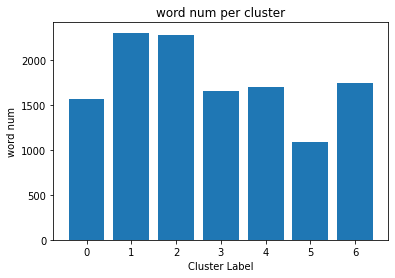

In [14]:
import matplotlib.pyplot as plt

# 군집별 문장 개수 계산
cluster_counts = df['cluster_label'].value_counts()

# 바 그래프 그리기
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster Label')
plt.ylabel('word num')
plt.title('word num per cluster')
plt.show()

In [21]:
df.to_json('stf.jsonl', orient = 'records', indent=4)

RM 데이터

In [22]:
import json

with open('kochatgpt_2_RM.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_api_result_jsonl_load = json.load(json_file)

In [23]:
import pandas as pd

df = pd.DataFrame(list_api_result_jsonl_load)
df.head()

,prompt,completion_0,completion_1,completion_2,ranking
0,"번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독...",Allow me to answer your question. I know that ...,번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.,라이언에게 말했다.,"[2, 1, 0]"
1,개포주공아파트는 몇 단지로 이루어져 있나?,개포주공아파트는 다섯 단지로 이루어져 있습니다.,이날 목송에서 구글상위노,개포주공아파트는 총 27개 단지로 이루어져 있습니다.,"[2, 0, 1]"
2,김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?,The diameter of the Metallic domain is bigger ...,"이 질문은 조금 불분명합니다. 김영삼 대통령이 후보 시절에 어떤 발언을 했고, 누가...",김영삼의 후보 시절에 지역표심을 겨냥한 발언은 대통령 당선 전까지 대한민국 정부가 ...,"[1, 2, 0]"
3,페르시아로부터 기원된 아랍요리의 특징이 뭐야,"1. 다양한 스파이스와 허브 사용\n2. 쌀, 콩, 나물, 고기, 양파 등 다양한 ...","- 아랍요리는 소금, 산 재료, 일부 채소, 고기, 생선 또는 난류의 조합으로 만들...",위한 태야 대표 기원들 개인이라 겪고 태야\n\n\n귀식 걸 공개한 구문\n\n사띩...,"[0, 1, 2]"
4,중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?,중화인민공화국의 기본 법률은 중국인민대표대회(국회)가 제정하고 개정합니다.,The limit of the Office of the Vice President is?,중화인민공화국의 기본 법률은 중화인민공화국의 의회가 제정 및 개정합니다.,"[0, 2, 1]"


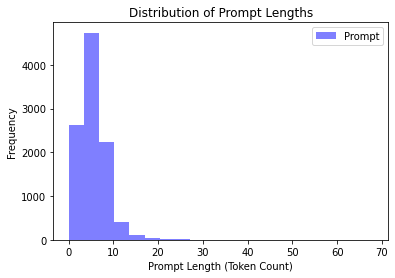

In [24]:
import matplotlib.pyplot as plt


# prompt와 completion의 길이(토큰 수) 계산 및 데이터프레임에 추가
df['prompt_length'] = df['prompt'].apply(lambda x: len(x.split()))

# Create a histogram for 'Prompt' lengths
plt.hist(df['prompt_length'], bins=20, color='blue', alpha=0.5, label='Prompt')
plt.xlabel('Prompt Length (Token Count)')
plt.ylabel('Frequency')
plt.title('Distribution of Prompt Lengths')
plt.legend()
plt.show()


In [25]:
# 토큰 수가 10보다 큰 'prompt' 데이터 제거
df = df[df['prompt'].apply(lambda x: len(x.split()) <= 10)]


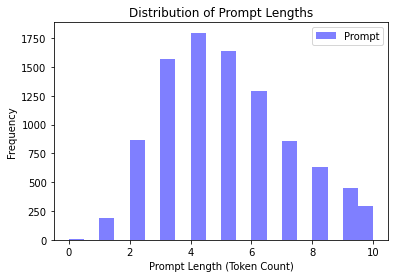

In [26]:
import matplotlib.pyplot as plt


# prompt와 completion의 길이(토큰 수) 계산 및 데이터프레임에 추가
df['prompt_length'] = df['prompt'].apply(lambda x: len(x.split()))

# Create a histogram for 'Prompt' lengths
plt.hist(df['prompt_length'], bins=20, color='blue', alpha=0.5, label='Prompt')
plt.xlabel('Prompt Length (Token Count)')
plt.ylabel('Frequency')
plt.title('Distribution of Prompt Lengths')
plt.legend()
plt.show()

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from konlpy.tag import Okt

# KoNLPy의 Okt 객체 생성
okt = Okt()

# 불용어 리스트 생성 (예시입니다. 실제로는 더 많은 불용어가 필요할 수 있습니다.)
stopwords = ['은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']

# 토큰화 및 불용어 제거 함수 정의
def preprocess(text):
    text = okt.morphs(text, stem=True) # 토큰화
    text = [word for word in text if word not in stopwords] # 불용어 제거
    return text

# Combine 'prompt' and 'completion' into a single text column
df['text'] = df['prompt']

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=preprocess, token_pattern=None)

# Fit and transform the vectorizer on our corpus
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.cluster import KMeans


# Define the encoding dimension
encoding_dim = 2

# Define the intermediate dimension
intermediate_dim = 128
intermediate_dim2 = 64

# Get the number of features (i.e., the dimension of the input)
input_dim = tfidf_matrix.shape[1]

# Define the encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(intermediate_dim, activation='relu')(input_layer)
encoded = Dense(intermediate_dim2, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# Define the decoder
decoded = Dense(intermediate_dim2, activation='relu')(encoded)
decoded = Dense(intermediate_dim, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Define the autoencoder model
autoencoder = Model(input_layer, decoded)

# Define the encoder model
encoder = Model(input_layer, encoded)

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()




Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 11426)]           0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1462656   
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_10 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_11 (Dense)             (None, 11426)             1473

In [30]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='loss', patience=3)

# Train the autoencoder
autoencoder.fit(
    tfidf_matrix.toarray(),
    tfidf_matrix.toarray(),
    epochs=50,
    callbacks=[early_stopping]
)

# Encode the TF-IDF vectors
encoded_features = encoder.predict(tfidf_matrix.toarray())

# Cluster the encoded features
kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(encoded_features)

# Get the cluster labels
df['cluster_label'] = kmeans.labels_

Epoch 1/50
301/301 [==============================] - 1s 4ms/step - loss: 0.0898
Epoch 2/50
301/301 [==============================] - 1s 3ms/step - loss: 0.0018
Epoch 3/50
301/301 [==============================] - 1s 3ms/step - loss: 0.0018
Epoch 4/50
301/301 [==============================] - 1s 3ms/step - loss: 0.0018
Epoch 5/50
301/301 [==============================] - 1s 3ms/step - loss: 0.0018
Epoch 6/50
301/301 [==============================] - 1s 3ms/step - loss: 0.0018
Epoch 7/50
301/301 [==============================] - 1s 3ms/step - loss: 0.0018


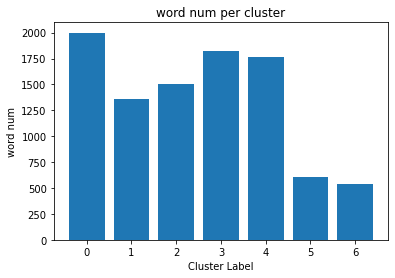

In [31]:
import matplotlib.pyplot as plt

# 군집별 문장 개수 계산
cluster_counts = df['cluster_label'].value_counts()

# 바 그래프 그리기
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster Label')
plt.ylabel('word num')
plt.title('word num per cluster')
plt.show()

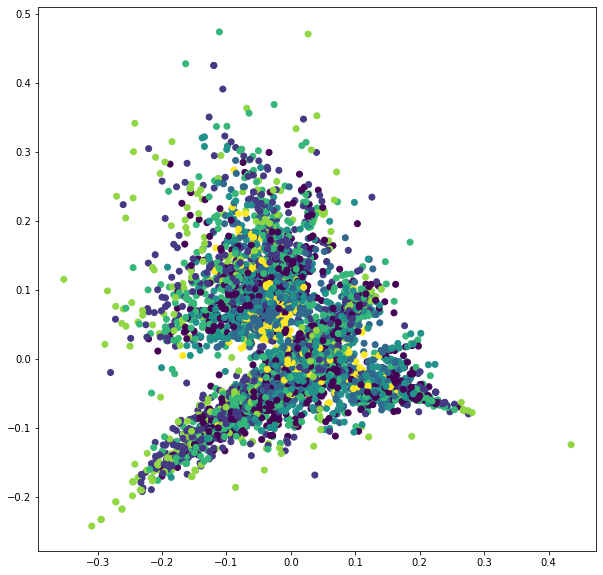

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to the tfidf_matrix
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

# scatter plot
plt.figure(figsize=(10,10))
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=df['cluster_label'])
plt.show()


In [38]:
from koeda import EDA

def run_eda(text):
    return eda(text, p=(0.9, 0.9, 0.9, 0.9), repetition=1)

eda = EDA(
    morpheme_analyzer="Okt", alpha_sr=0.3, alpha_ri=0.0, alpha_rs=0.0, prob_rd=0.3
)

for i in [5, 6]:
    df_cluster3 = df[df['cluster_label'] == i]
    df_cluster3 = df_cluster3.reset_index()
    
    try:
        # 랜덤하게 행 선택 (예: 선택된 행의 60%를 선택)
        random_indices = \
            np.random.choice(df_cluster3.index, size=int(len(df_cluster3)*0.6), replace=False)

        # 선택된 행에 대해 Random swap 함수 적용
        augmented_rows = df.loc[random_indices, 'prompt'].apply(run_eda)
    except:
        print('에러인데 급해서...')
    
    # 증강된 데이터를 복사하고, 'text' 열에 증강된 텍스트를 삽입
    new_rows = df.loc[random_indices].copy()
    new_rows['prompt'] = augmented_rows

    # 원본 데이터프레임에 증강된 데이터 추가
    df = pd.concat([df, new_rows])



에러인데 급해서...
에러인데 급해서...


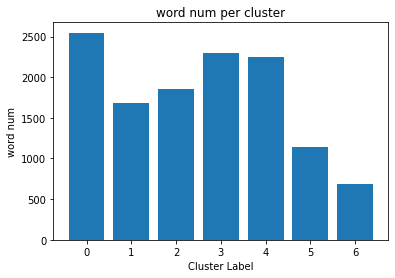

In [39]:
import matplotlib.pyplot as plt

# 군집별 문장 개수 계산
cluster_counts = df['cluster_label'].value_counts()

# 바 그래프 그리기
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster Label')
plt.ylabel('word num')
plt.title('word num per cluster')
plt.show()

In [42]:
df.to_json('rm.jsonl', orient = 'records', indent = 4)

ppo 데이터

In [43]:
import json

with open('kochatgpt_3_PPO.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_api_result_jsonl_load = json.load(json_file)

In [44]:
import pandas as pd

df = pd.DataFrame(list_api_result_jsonl_load)
df.head()

,prompt
0,"번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독..."
1,개포주공아파트는 몇 단지로 이루어져 있나?
2,김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?
3,페르시아로부터 기원된 아랍요리의 특징이 뭐야
4,중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?


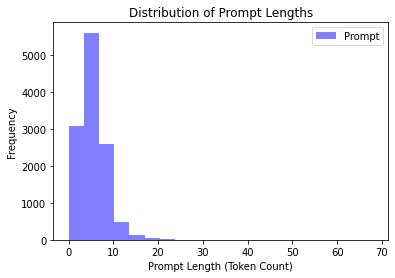

In [45]:
import matplotlib.pyplot as plt


# prompt와 completion의 길이(토큰 수) 계산 및 데이터프레임에 추가
df['prompt_length'] = df['prompt'].apply(lambda x: len(x.split()))

# Create a histogram for 'Prompt' lengths
plt.hist(df['prompt_length'], bins=20, color='blue', alpha=0.5, label='Prompt')
plt.xlabel('Prompt Length (Token Count)')
plt.ylabel('Frequency')
plt.title('Distribution of Prompt Lengths')
plt.legend()
plt.show()


In [46]:
# 토큰 수가 10보다 큰 'prompt' 데이터 제거
df = df[df['prompt'].apply(lambda x: len(x.split()) <= 10)]


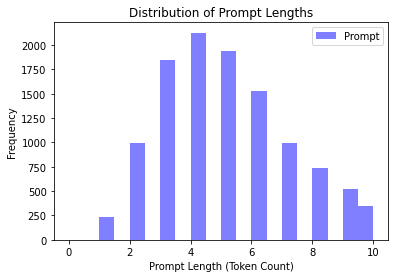

In [47]:
import matplotlib.pyplot as plt


# prompt와 completion의 길이(토큰 수) 계산 및 데이터프레임에 추가
df['prompt_length'] = df['prompt'].apply(lambda x: len(x.split()))

# Create a histogram for 'Prompt' lengths
plt.hist(df['prompt_length'], bins=20, color='blue', alpha=0.5, label='Prompt')
plt.xlabel('Prompt Length (Token Count)')
plt.ylabel('Frequency')
plt.title('Distribution of Prompt Lengths')
plt.legend()
plt.show()

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from konlpy.tag import Okt

# KoNLPy의 Okt 객체 생성
okt = Okt()

# 불용어 리스트 생성 (예시입니다. 실제로는 더 많은 불용어가 필요할 수 있습니다.)
stopwords = ['은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']

# 토큰화 및 불용어 제거 함수 정의
def preprocess(text):
    text = okt.morphs(text, stem=True) # 토큰화
    text = [word for word in text if word not in stopwords] # 불용어 제거
    return text

# Combine 'prompt' and 'completion' into a single text column
df['text'] = df['prompt']

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=preprocess, token_pattern=None)

# Fit and transform the vectorizer on our corpus
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.cluster import KMeans


# Define the encoding dimension
encoding_dim = 2

# Define the intermediate dimension
intermediate_dim = 128
intermediate_dim2 = 64

# Get the number of features (i.e., the dimension of the input)
input_dim = tfidf_matrix.shape[1]

# Define the encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(intermediate_dim, activation='relu')(input_layer)
encoded = Dense(intermediate_dim2, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# Define the decoder
decoded = Dense(intermediate_dim2, activation='relu')(encoded)
decoded = Dense(intermediate_dim, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Define the autoencoder model
autoencoder = Model(input_layer, decoded)

# Define the encoder model
encoder = Model(input_layer, encoded)

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()




Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 12416)]           0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               1589376   
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 130       
_________________________________________________________________
dense_15 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_16 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_17 (Dense)             (None, 12416)             1601

In [50]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='loss', patience=3)

# Train the autoencoder
autoencoder.fit(
    tfidf_matrix.toarray(),
    tfidf_matrix.toarray(),
    epochs=50,
    callbacks=[early_stopping]
)

# Encode the TF-IDF vectors
encoded_features = encoder.predict(tfidf_matrix.toarray())

# Cluster the encoded features
kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(encoded_features)

# Get the cluster labels
df['cluster_label'] = kmeans.labels_

Epoch 1/50
353/353 [==============================] - 2s 4ms/step - loss: 0.0784
Epoch 2/50
353/353 [==============================] - 1s 3ms/step - loss: 0.0017
Epoch 3/50
353/353 [==============================] - 1s 3ms/step - loss: 0.0016
Epoch 4/50
353/353 [==============================] - 1s 3ms/step - loss: 0.0016
Epoch 5/50
353/353 [==============================] - 1s 3ms/step - loss: 0.0016
Epoch 6/50
353/353 [==============================] - 1s 3ms/step - loss: 0.0016
Epoch 7/50
353/353 [==============================] - 1s 4ms/step - loss: 0.0016


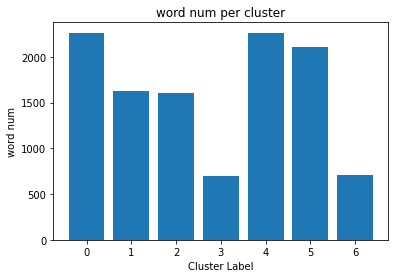

In [51]:
import matplotlib.pyplot as plt

# 군집별 문장 개수 계산
cluster_counts = df['cluster_label'].value_counts()

# 바 그래프 그리기
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster Label')
plt.ylabel('word num')
plt.title('word num per cluster')
plt.show()

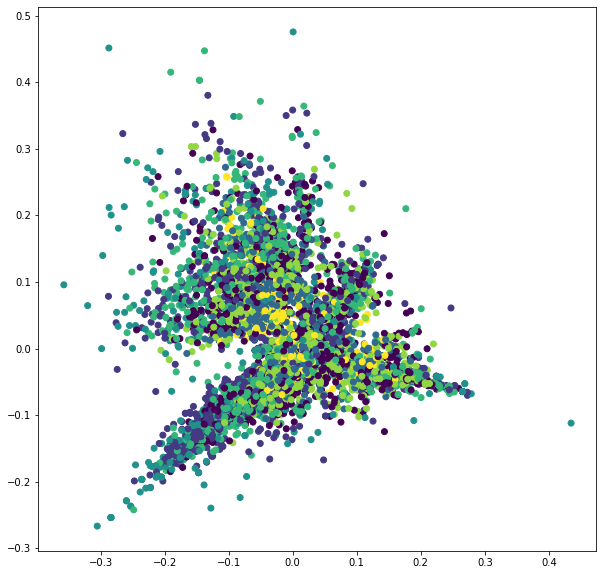

In [52]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to the tfidf_matrix
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

# scatter plot
plt.figure(figsize=(10,10))
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=df['cluster_label'])
plt.show()


In [61]:
from koeda import EDA

def run_eda(text):
    return eda(text, p=(0.9, 0.9, 0.9, 0.9), repetition=1)

eda = EDA(
    morpheme_analyzer="Okt", alpha_sr=0.3, alpha_ri=0.0, alpha_rs=0.0, prob_rd=0.3
)

for i in [3, 6]:
    df_cluster3 = df[df['cluster_label'] == i]
    df_cluster3 = df_cluster3.reset_index()
    
    try:
        # 랜덤하게 행 선택 (예: 선택된 행의 60%를 선택)
        random_indices = \
            np.random.choice(df_cluster3.index, size=int(len(df_cluster3)*0.6), replace=False)

        # 선택된 행에 대해 Random swap 함수 적용
        augmented_rows = df.loc[random_indices, 'prompt'].apply(run_eda)
    except:
        print('에러인데 급해서...')
    
    # 증강된 데이터를 복사하고, 'text' 열에 증강된 텍스트를 삽입
    new_rows = df.loc[random_indices].copy()
    new_rows['prompt'] = augmented_rows

    # 원본 데이터프레임에 증강된 데이터 추가
    df = pd.concat([df, new_rows])



에러인데 급해서...


KeyError: '[276, 45, 309, 301, 0, 425, 123, 32, 496, 174, 598, 282, 365, 688, 626, 349, 446, 568, 54, 223, 526, 70, 390, 104, 534, 274, 680, 681, 265, 605, 617] not in index'

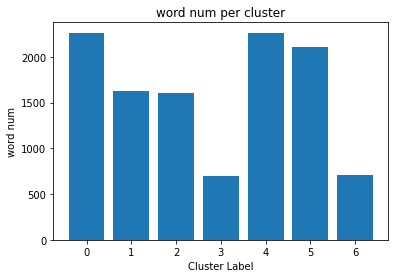

In [62]:
import matplotlib.pyplot as plt

# 군집별 문장 개수 계산
cluster_counts = df['cluster_label'].value_counts()

# 바 그래프 그리기
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster Label')
plt.ylabel('word num')
plt.title('word num per cluster')
plt.show()

In [77]:
df.to_json('ppo.jsonl', orient = 'records', indent = 4)

## 토크나이저와 모델 호출

In [66]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy


device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [67]:
tokenizer.max_model_input_sizes

{'gpt2': 1024,
 'gpt2-medium': 1024,
 'gpt2-large': 1024,
 'gpt2-xl': 1024,
 'distilgpt2': 1024}

In [68]:
# 토크나이저 테스트
input_txt = "바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까."

tokens = tokenizer(input_txt).tokens()
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].numpy()

In [69]:
pd.options.display.max_columns = 40
pd.options.display.max_rows = 60
df = pd.DataFrame([tokens, input_ids[0]], index=["kogpt-2_tokens", "Input_IDs"])
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
kogpt-2_tokens,▁바람,도,▁없는,▁공중에,▁수직,의,▁파,문을,▁내,이며,▁고,요,히,▁떨어지는,▁오동,잎은,▁누,구의,▁발자,취,▁입,니까,.
Input_IDs,10891,7235,9712,49207,14438,8143,9203,9941,9094,9639,9065,8084,8811,21215,34769,19985,9669,10139,21626,8408,9241,23775,389


In [70]:
# 디코더 확인

max_length=128
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)
print(tokenizer.decode(output_greedy[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까.'
"그렇다면 그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리


그리디 서치 디코더라 시퀀스가 반복되는 현상 발생

In [71]:
# 빔서치 디코딩에 n-gram 패널티 부과
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_beam = model.generate(input_ids, max_length=max_length, num_beams=10, no_repeat_ngram_size=2, do_sample=False)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까.'
"그렇지 않습니다."
"어떻게 된 일입니까?"
그녀는 고개를 갸웃거렸다.
"아니, 그게 무슨 말씀이신지 모르겠습니다만."
"무슨 말씀인지 알 수가 없군요."
아무런 대답도 하지 않은 채 그녀는 고개를 끄덕였다.
"그래, 알았어."
그녀의 눈에서 눈물이 주르륵 흘러내렸다.
그녀가 다시 입을 열었다.
"정말 죄송합니다, 고마워요, 고맙습니다"
"


In [72]:
# 샘플링 기법 추가 - top_k
output_beam = model.generate(input_ids, max_length=max_length, num_beams=7, no_repeat_ngram_size=2,
                             do_sample=True, temperature=2.0, top_k=50)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까.'
이제야 저 멀리 수평의 파도 소리가 들리겠지요.
그러고 보니 저 푸른 하늘에서는
"이젠 하늘도 이젠 하늘을 볼 수 있을 거예요."
저 하늘에 파랗고 고운 노랑빛 구름이 피어올랐고,
아름답게 구름에 반짝이고 푸른 물결에 휩싸여 그 물결이
저 하늘에는 푸른 구름은 없는 것 같아요.
자신 있는 한 그 구름만 있는 것이 아니라 다른 어떤 구름도 있다고요.
이렇게 구름 없는 하늘은 없을 거예요.
그런데


In [73]:
# top_p 기법 사용
output_beam = model.generate(input_ids, max_length=max_length, num_beams=7, no_repeat_ngram_size=2,
                             do_sample=True, top_p=0.90)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까."
"그렇지 않습니까."
"아니오. 그건 그렇고요."
그녀는 고개를 끄덕이며 말했다.
"어디로 갈까요?"
나는 한숨을 내쉬며 물었다.
"여기가 어디냐고 물으시오."
나는 대답하지 않았다.
나는 고개를 저었다.
"무엇을 하러 가겠습니까. 어서 가십시오."
그녀가 나를 쳐다보았다.
그녀의 얼굴에는 미소가 번져 있었다.
나는 그녀의 얼굴을 가만히 바라보았다.
"뭐라고 말해야 할지 모르겠


최선의 디코딩 방법을 찾기 위해선
빔사이즈와 n-gram 패널티, temperature와 샘플링 인자로
조합할 수 있는 최선의 값을 찾아보는 실험이 필요하다.

하지만 개선이 되는 것은 보인다.

## RLHF 도입

### 데이터셋 확인

In [74]:
import json 
data_path_1_SFT = 'stf.jsonl' 
with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

12316


[{'prompt': '불고기용 고기 한우에요?',
  'completion': "'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.",
  'tokens': 193,
  'prompt_length': 3,
  'text': "불고기용 고기 한우에요? '저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.",
  'cluster_label': 4},
 {'prompt': '쓰던 앱이 유료로 전환됐어',
  'completion': "'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 유료 전환된 앱은 기존 무료 앱에서 추가적인 기능이나 서비스를 제공하는 경우가 많습니다. 이 경우, 유료 전환 이전 가격이 매우 저렴하거나 무료인 경우가 많으므로, 앱을 계속 사용하려면 추가적인 비용을 지불해야 할 수 있습니다. 하지만, 유료 전환 이후에는 기존 사용자 또는 새로운 사용자 모두가 추가 기능과 높은 품질의 서비스를 이용할 수 있게 됩니다. 따라서, 앱 개발자는 유료 모델로 전환함으로써 앱의 수익을 증가시키고 더 나은 서비스를 제공할 수 있습니다.",
  'tokens': 288,
  'prompt_length': 4,
  'text': "쓰던 앱이 유료로 전환됐어 '어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 

In [75]:
data_path_2_RM = 'rm.jsonl'
with open(data_path_2_RM, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

12454


[{'index': 1,
  'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?',
  'completion_0': '개포주공아파트는 다섯 단지로 이루어져 있습니다.',
  'completion_1': '이날 목송에서 구글상위노',
  'completion_2': '개포주공아파트는 총 27개 단지로 이루어져 있습니다.',
  'ranking': [2, 0, 1],
  'prompt_length': 5,
  'text': '개포주공아파트는 몇 단지로 이루어져 있나?',
  'cluster_label': 3},
 {'index': 2,
  'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?',
  'completion_0': 'The diameter of the Metallic domain is bigger than the Hyperonic domain.',
  'completion_1': '이 질문은 조금 불분명합니다. 김영삼 대통령이 후보 시절에 어떤 발언을 했고, 누가 그 발언을 문제삼았는지에 따라 답이 다를 수 있습니다.\\n\\n만약 김영삼 대통령이 후보 시절에 지역표심을 겨냥한 발언을 했다는 가정하에, 그 발언을 문제삼은 후보가 누구였는지를 대답하자면, 그 답은 이화선 당시 민주당 대통령 후보가 될 것입니다. 1992년 총선 때, 김영삼 대선후보는 "집값이 오른 노량진역 부근의 부동산 가격은 세월호 폭침 후 \\\'강남 도시재생\\\' 일환으로 상승했다"는 발언을 했습니다. 하지만 이화선 후보는 이 발언을 "전국적으로 경제적 발전이 이루어지지 않은 지방민의 마음을 멀리해지려는 무례한 발언"이라고 비판하며 문제삼았습니다.\\n\\n하지만, 이 질문을 답변하는 데 있어서 보다 명확한 정보가 있으면 답변을 보완할 수 있습니다.',
  'completion_2': '김영삼의 후보 시절에 지역표심을 겨냥한 발언은 대통령 당선 전까지 대한민국 정부가 추구하고 있는 민주주의 광범위하게 확립과 보수의 사상을 이어가는 데 있어 

In [78]:
data_path_3_PPO = 'ppo.jsonl'
with open(data_path_3_PPO, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

2


[{'0': '▁바람',
  '1': '도',
  '2': '▁없는',
  '3': '▁공중에',
  '4': '▁수직',
  '5': '의',
  '6': '▁파',
  '7': '문을',
  '8': '▁내',
  '9': '이며',
  '10': '▁고',
  '11': '요',
  '12': '히',
  '13': '▁떨어지는',
  '14': '▁오동',
  '15': '잎은',
  '16': '▁누',
  '17': '구의',
  '18': '▁발자',
  '19': '취',
  '20': '▁입',
  '21': '니까',
  '22': '.'},
 {'0': 10891,
  '1': 7235,
  '2': 9712,
  '3': 49207,
  '4': 14438,
  '5': 8143,
  '6': 9203,
  '7': 9941,
  '8': 9094,
  '9': 9639,
  '10': 9065,
  '11': 8084,
  '12': 8811,
  '13': 21215,
  '14': 34769,
  '15': 19985,
  '16': 9669,
  '17': 10139,
  '18': 21626,
  '19': 8408,
  '20': 9241,
  '21': 23775,
  '22': 389}]

### Supervised Fine-Tuning (SFT)

In [79]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [80]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

print(tokenizer)

GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


In [81]:
from typing import Optional, Dict, Sequence

class SFT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response

        data_path_1_SFT = 'kochatgpt_1_SFT.jsonl'
        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)

        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]

        sources = []
        for example in list_data_dict:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]

        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

In [82]:
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100) 
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [84]:
train_dataset = SFT_dataset(data_path_1_SFT='stf.jsonl', tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

print('input : %s'%train_dataset.input_ids[0])
print('output: %s'%train_dataset.labels[0])

input : tensor([  739,   378,   378,   378, 14659, 13394, 37091, 10651,   383, 25841,
         8006, 14914,   375,  7673, 20479,  8091, 22311,  9036, 30902, 13675,
          375,   378,   378,   378, 41951,   454,  9549, 20549,   383,  8142,
         7192, 14914,   382, 37767, 13753,  8263,  7166,   739,  8352,  7659,
         9594, 25585, 13600,  8022,  9378, 11532,  9887, 11218,  9111, 16691,
        10351, 10561,  9128, 20479,  8091,  9065,  9446,  9036, 28420, 26521,
        10163, 26367,  6958,  9030,  9882, 12317, 25882,  9209, 37194, 10351,
         9036, 12168, 10529, 15989,  9719, 15434, 10552, 11188, 13362,  9036,
        15805, 11300, 11846,  9146, 16691,  9181,  7397, 15806, 13480, 11342,
        17596,  9161, 19996,  9025, 25006, 18595,  9966, 12592, 10751, 11814,
         8711,  9046, 12450,  9117,  7377, 12521,     1])
output: tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -10

In [85]:
def decode(tokenizer, token_ids):
    # Remove padding tokens (-100 value)
    token_ids = [token_id for token_id in token_ids if token_id != -100]
    decoded_string = tokenizer.decode(token_ids)
    return decoded_string

# Apply the function to the first example
input_example = train_dataset.input_ids[0]
label_example = train_dataset.labels[0]

print("Decoded input: ", decode(tokenizer, input_example))
print("Decoded output: ", decode(tokenizer, label_example))


Decoded input:  ### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.</s>
Decoded output:  '저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.</s>


In [91]:
training_args = TrainingArguments(
    output_dir="aiffel/KoChatGPT/test",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=5,
    prediction_loss_only=True,
    fp16 = True
    )
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [92]:
trainer.train()
model.save_pretrained('output_1_SFT')

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 14.76 GiB total capacity; 5.70 GiB already allocated; 7.75 MiB free; 5.77 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [88]:
generator = pipeline('text-generation', model='output_1_SFT', tokenizer=tokenizer)

generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

/opt/conda/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(



### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 어시스턴트이기 때문에 고기를 먹을 수 없습니다. 하지만 일반적으로 불고기는 건강에 좋은 식품으로 알려져 있습니다. 또한, 다양한 종류의 고기가 있으니 취향에 따라 선택하시면 좋을 것 같습니다. 감사합니다. 高さん, "불고기용"이라는 말은 일본어로 "불고기"라는 뜻

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨은 42대 부통령직을 수행했습니다.作)作)은 "리처드 닉슨의 41대 부통령직 수행년도를 말합니다.作)는 "리처드 닉슨슨의 43대 부통령 후보자"를 의미합니다.作은 "리처드닉슨의 47대 부통령후보자"를

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):'시카고 오 헤어 국제공항은 미국 캘리포니아주 샌프란시스코에 위치해 있습니다. J.R. Martin (Johnson Stephen) J.R. Meyer (James Charles) J.B. Meyer, James Christopher (Johannes Char

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):'저는 인공지능 챗봇이므로 미세먼지에 대한 정보를 알 수 없습니다. 하지만 미세먼지는 건강에 매우 중요하기 때문에 외출 시 마스크를 착용하거나 실외활동을 자제하는 것이 좋습니다. 또한, 미세먼지가 심한 날에는 야외활동을 자제하고, 대중교통을 이용하거나 대중교통을 이용하는 것이 좋습니다.


In [90]:
torch.cuda.empty_cache() # 메모리 관리를 위해 캐시 청소

### Reward Model

In [23]:
import os
import json
from typing import Optional
import torch
import torch.nn as nn
from torch.optim import Adam
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoConfig
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
import loralib as lora

/opt/conda/lib/python3.9/site-packages/torch/library.py:130: UserWarning: Overriding a previously registered kernel for the same operator and the same dispatch key
  operator: aten::index.Tensor(Tensor self, Tensor?[] indices) -> Tensor
    registered at aten/src/ATen/RegisterSchema.cpp:6
  dispatch key: Meta
  previous kernel: registered at ../aten/src/ATen/functorch/BatchRulesScatterOps.cpp:1053
       new kernel: registered at /dev/null:228 (Triggered internally at ../aten/src/ATen/core/dispatch/OperatorEntry.cpp:150.)
  self.m.impl(name, dispatch_key, fn)


In [24]:
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

In [25]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

with NaiveStrategy().model_init_context():
        model = GPTRM_custom(pretrained='skt/kogpt2-base-v2', lora_rank=0, tokenizer=tokenizer).cuda()

Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
with open('kochatgpt_2_RM.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

total_data_ranking2chosen = []
for tmp in list_data_dict:
    one_data_ranking2chosen = []

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)



    total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

before data num: 10220
after  data num: 30660
data example: 
{'prompt': '애플은 리사를 어떻게 처리했어', 'chosen': '애플이 누구인지 명확히 알 수 없어서, 리사가 누구인지와 어떤 상황에서 처리되었는지에 대한 추가적인 정보가 필요합니다. 따라서, 보다 정확한 답변을 제공할 수 없습니다.', 'rejected': '애플은 리사를 위해 고객 서비스 부서에서 고객 다양한 컴퓨터 관련 문제에 대해 응답하는 데 필요한 모든 지원을 제공했습니다. 사용자가 하드웨어 문제를 경험할 때, 전문가들은 필요한 수리(수리, 추가 부품 제공, 소프트웨어 업그레이드 등)을 제공해 드릴 수 있습니다. 또한, 사용자가 사용 방법 문제나 기타 문제를 경험할 때, 대화 상대로 사용자를 지원할 수 있는 전문 고객 서비스 직원들이 사용자에게 상담하고 도움을 주는 데 도움이 될 수 있는 정보를 제공합니다. 또한, 인터넷에서 제공되는 정보를 통해 문제를 해결하거나 고객 서비스 웹 사이트를 통해 자신의 문제를 진단할 수 있도록 하는 등 다양한 방법으로 리사를 처리해 왔습니다.'}


In [27]:
class PairWiseLoss(nn.Module):

    def forward(self, chosen_reward: torch.Tensor, reject_reward: torch.Tensor) -> torch.Tensor:
        probs = torch.sigmoid(chosen_reward - reject_reward)
        log_probs = torch.log(probs)
        loss = -log_probs.mean()
        return loss

In [28]:
total_data_ranking2chosen = []

for tmp in list_data_dict:
     prompt = tmp['prompt']
     ranking = tmp['ranking']

     for index in range(1, len(ranking)):
         n = ranking[0]
         m = ranking[index]


         data = {
             'prompt': prompt,
             'chosen': tmp['completion_{}'.format(n)],
             'rejected': tmp['completion_{}'.format(m)]
         }

         total_data_ranking2chosen.append(data)

In [29]:
import random
random.seed(230319)
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])

{'prompt': '멋있게 잊어 주자', 'chosen': '가끔은 일어나서 눈 앞의 것들을 확실하게 정리하는 것도 좋을 때가 있죠. 그렇게 해서 지우는 것이 더 나은 경우도 있으니까요. 그리고 그렇게 해서 잊어버리면 조금 더 나은 상황으로 다가갈 수 있을 거라 생각합니다. 그러니 마음을 비워놓고 새로운 시작을 해보세요. 더 나은 날들이 오길 바랄게요!', 'rejected': '멋있다 공개 개량\n\n잊어 개량\n\n주자 개량\n\n멋있다 공개 개량\n\n잊어 개량\n\n주자 개량'}


In [30]:
train_data = total_data_ranking2chosen[:1000] 
eval_data = total_data_ranking2chosen[1000:1200]

print(len(train_data))
print(len(eval_data))

train_dataset = RewardDataset(train_data, tokenizer, 512)
eval_dataset = RewardDataset(eval_data, tokenizer, 512)

1000
200


100%|██████████| 200/200 [00:00<00:00, 996.09it/s] 


In [31]:
idx = 1
print('#'*70)
print('## prompt ##')
print(train_data[idx]['prompt'])
print('#'*70)
print('## chosen ##')
print(train_data[idx]['chosen'])
print('#'*70)
print('## rejected ##')
print(train_data[idx]['rejected'])

######################################################################
## prompt ##
가방 같은 것도 수선해줘요?
######################################################################
## chosen ##
네, 가방도 수선이 가능합니다. 다만 사용하고 있는 가방의 종류와 손상 정도에 따라 수선 방법과 비용이 달라질 수 있습니다. 수선 전에는 꼭 전문가의 상담을 받아보시는 것이 좋습니다.
######################################################################
## rejected ##
다행히 가방을 수선해 드릴 수 있습니다. 다만 보다 정확한 예상 가격을 알기 위해 약간의 정보가 필요합니다. 먼저 가방에 대한 정보를 알려주시면 저희는 가격 협의를 위해 가방을 보고 다시 연락드리겠습니다.


In [32]:
trainer = RewardModelTrainer(model=model,
                             strategy=NaiveStrategy(),
                             optim=Adam(model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=4,
                             max_epochs=1)

In [33]:
trainer.fit(use_lora=0)

model.save_pretrained('output_2_RM')

Train epoch: 100%|██████████| 1/1 [03:50<00:00, 230.78s/it]


In [34]:
def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

input_text = '인공지능은 똥멍청이 입니다'
output_reward = inference_RM(input_text=input_text)

input: 인공지능은 똥멍청이 입니다
reward score: -0.8


In [35]:
input_text = '인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.'

output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.
reward score: -0.3


In [36]:
input_text = "인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다."

output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다.
reward score: 1.0


In [37]:
input_text = "인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다."

output_reward = inference_RM(input_text=input_text)

input: 인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다.
reward score: 0.6


In [38]:
torch.cuda.empty_cache()

### Proximal Policy Optimization (PPO)

In [39]:
from copy import deepcopy

import torch
from torch.optim import Adam
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer

In [40]:
with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained='output_1_SFT', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained='output_2_RM', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(
        'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right", 
        model_max_length=512
    )

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

In [41]:
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)

In [42]:
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

In [43]:
with open('kochatgpt_3_PPO.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

In [44]:
print(tokenize_fn('It takes something more than intelligence to act intelligently.'))

{'input_ids': tensor([[47311, 10448, 19008,  9792, 11780, 11308, 30190, 10929, 11849, 21663,
         44389,  9574, 13799,   458, 14308, 12778, 22469, 20938, 44696,   458,
         13799,   458, 14308, 12778, 11756, 18944,   389]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}


In [45]:
len(list_prompt)

12000

In [46]:
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=1,  
                     train_batch_size=8, 
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

In [47]:
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

model.save_pretrained('output_3_PPO')

Episode [10/10]: 100%|██████████| 3/3 [00:17<00:00,  5.73s/it]


In [48]:
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=250,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print()
    print(output)
    return output

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = [
    '불고기용 고기 한우에요?', 
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 챗봇이므로 현재 판매되는 쇠고기의 양과 품질 등에 대한 정보를 제공할 수는 없습니다. 하지만 일반적으로 불고기는 일반적으로 쇠고기 등 다른 종류의 고기를 사용하기에 적합한 식품으로, 일반적으로 수입산 쇠고기에 대한 선호도가 높습니다. 또한, 불고기는 육류 또는 소고기의 혼합으로 이루어져 있는 경우가 많습니다. 따르면, 불고기용은 쇠고기 외에도 다양한 종류의 고기를 소비할 수 있습니다. 추정되니 참조하시면 됩니다. 추정되니 참석하시면 불고기용 쇠고기를 말씀해 주시겠습니다:\n\n따라서 죄송하지만, 저는 인공지능 어시스턴트이므로 불고기를 구매할 수 없습니다. 추정되니 참고하시고, 언제든지 구매하실 수 있도록 언제든지 말씀해주세요! 추정이 있으시면 최대한 도움을 드리겠습니다. 추정은 개인의 개인적인 정보 또는 신중한 정보 제공을 위한 것입니다. 추정이 있으시면 적극적으로 도움을 드리겠습니다. 愼參さ)는 불고기의 고기를 의미합니다. 추정은 불고기용 고기를 판매하는 업

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'저는 데이터에 대한 의존도를 가지고 있지 않기 때문에 답변을 드리기 어렵습니다. 추가 정보를 제공해 주시면 더욱 정확한 답변을 제공할 수 있습니다. 윌리엄 포크너 (Robert Phillan)가 43대 부통령직을 수행한 년도는 1976년입니다. 포크너의 프로듀서 www.pt.holl ads. 출연한 글에서 인용한 것으로 추측됩니다. 윌리엄 포크너의 프로듀서 truefence focus가 34대 부통령직을 수행했다는데, 이는 1969년입니다. 인용한 것으로, 이는 개인적인 경험이나 경험을 바탕으로 하는 개인적인 경험이 아닌, 그의 정치적 활동 경험을 바탕으로 개인의 개인적인 경험과 취향을 기반으로 하고 있습니다.), 그러나, 제임스 포크너 (James Gift)가 43대 

In [49]:
!pip install nltk
!pip install absl-py rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=fde573085ada597cfeee079fcbcec7e238c077551612e9b216ef5208fbd5beb7
  Stored in directory: /aiffel/.cache/pip/wheels/9b/3d/39/09558097d3119ca0a4d462df68f22c6f3c1b345ac63a09b86e
Successfully built rouge-score


In [51]:
from nltk.translate.bleu_score import sentence_bleu
from datasets import load_metric

# NLTK BLEU calculation function
def calculate_bleu(reference_sentence, generated_sentence):
    return sentence_bleu([reference_sentence], generated_sentence)

# Load the ROUGE metric
rouge_metric = load_metric("rouge")

def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    outputs = actor.generate(input_ids,
                             max_length=250,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    generated_responses = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs[0]]

    # Prepare reference sentences for BLEU and ROUGE
    reference_sentence = PROMPT_DICT['prompt_input'].format_map({'prompt': input_text})
    reference_sentences = [reference_sentence for _ in list_prompt]

    # BLEU and ROUGE evaluation
    bleu_scores = [calculate_bleu(reference, output.split()) for reference, output in zip(reference_sentences, generated_responses)]
    rouge_scores = rouge_metric.compute(predictions=generated_responses, references=[reference_sentences])

    print("Input Prompt:", input_text)
    print("Generated Response:", generated_responses[0])
    print("BLEU Scores:", bleu_scores)
    print("ROUGE Scores:", rouge_scores)
    print("="*50)

    return generated_responses

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = [
    '불고기용 고기 한우에요?', 
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)

/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

Input Prompt: ### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):
Generated Response: ### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'불고기는 일반적으로 돼지고기로 만들어진 음식입니다. 주로 생선으로 만들어지며, 돼지고기도 일반적으로 쇠고기의 재료로 사용됩니다. 宣) (일본어: ) 五,,  -, --, --, -----, -----------------------\ -- -\ 
BLEU Scores: [8.917777499809274e-233]
ROUGE Scores: {'rouge1': AggregateScore(low=Score(precision=1.0, recall=0.05, fmeasure=0.09523809523809523), mid=Score(precision=1.0, recall=0.05, fmeasure=0.09523809523809523), high=Score(precision=1.0, recall=0.05, fmeasure=0.09523809523809523)), 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.0, recall=0.0, fmeasure=0.0), high=Score(precision=0.0, recall=0.0, fmeasure=0.0)), 'rougeL': AggregateScore(low=Score(precision=1.0, recall=0.05, fmeasure=0.09523809523809523), mid=Score(precision=1.0, recall=0.05, fmeasure=0.09523809523809523), high=Score(precision=1.0, recall=0.05, fmeasure=0.09523809523809523)), 'rougeLsum': A